# Face Analysis

## Import

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import argparse
import sys
import random

sys.path.append('../') # import를 위해 경로추가

from modules import Utility as U

## Load data

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--path_csv', type=str, default="../data/train/train.csv")
parser.add_argument('--path_img', type=str, default="../data/train/images/")
args = parser.parse_args('')

In [3]:
train_df = pd.read_csv(args.path_csv)
images = []
for path in train_df['path']:
    __path_image = [os.path.join(*[args.path_img, path, p])  for p in os.listdir(args.path_img + path) if p[0] != '.' ]
    images.append(__path_image)
    
train_df['images'] = images

train_df.head()


,id,gender,race,age,path,images
0,000001,female,Asian,45,000001_female_Asian_45,[../data/train/images/000001_female_Asian_45/m...
1,000002,female,Asian,52,000002_female_Asian_52,[../data/train/images/000002_female_Asian_52/m...
2,000004,male,Asian,54,000004_male_Asian_54,[../data/train/images/000004_male_Asian_54/mas...
3,000005,female,Asian,58,000005_female_Asian_58,[../data/train/images/000005_female_Asian_58/m...
4,000006,female,Asian,59,000006_female_Asian_59,[../data/train/images/000006_female_Asian_59/m...


## Define cascade

In [11]:
cascade_filename1 = './haarcascade_frontalface_default.xml'
cascade1 = cv2.CascadeClassifier(cascade_filename1)
cascade_filename2 = './haarcascade_frontalface_alt.xml'
cascade2 = cv2.CascadeClassifier(cascade_filename2)
def detecter(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    results = cascade1.detectMultiScale(gray,            # 입력 이미지
                                   scaleFactor= 1.1,# 이미지 피라미드 스케일 factor
                                   minNeighbors=10,  # 인접 객체 최소 거리 픽셀
                                   minSize=(50,50)  # 탐지 객체 최소 크기
                                   )        
    for box in results:
        x, y, w, h = box
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), thickness=4)
    results = cascade2.detectMultiScale(gray,            # 입력 이미지
                                   scaleFactor= 1.1,# 이미지 피라미드 스케일 factor
                                   minNeighbors=10,  # 인접 객체 최소 거리 픽셀
                                   minSize=(50,50)  # 탐지 객체 최소 크기
                                   )        
    for box in results:
        x, y, w, h = box
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), thickness=2)

## Analysis

Simple Eq Hist
동일 인물 case도 밝기, 색조가 다르다. equalizeHist로 각 채널을 피면 더 이미지 간 차이가 더 뚜렷하게 나타난다.

Only Brightness Eq Hist
마찬가지로, 이미지 간 차이가 더 뚜렷해진다. 성능 향상이 도움이 안될것으로 판단된다.

Haarcascade detection
얼굴만 검출해서 모델에 넘겨줄 수 있다면 더 좋은 성능을 기대할 수 있다. 그러나 검출이 잘 안된다.

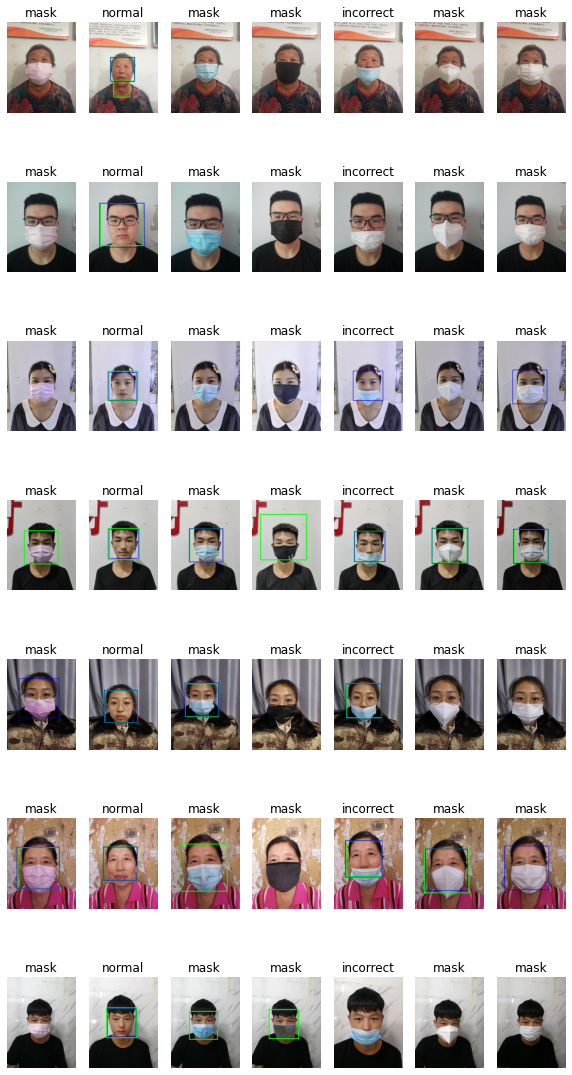

In [24]:
nrow, ncol = (7, 7)
path_sample_image = random.sample(images, nrow)
sample_images = []
for paths in path_sample_image:
    for path in paths:
        __state = path.split('/')[-1].split('.')[0]
        __img = cv2.imread(path)
        __img = cv2.cvtColor(__img, cv2.COLOR_BGR2RGB)
        # pre processing
        # * Simple Eq Hist
        # __img_splited = cv2.split(__img)
        # __img_splited = [cv2.equalizeHist(_i) for _i in __img_splited]
        # __img = cv2.merge(__img_splited)
        # * Only Brightness Eq Hist
        # __imgYCrCb = cv2.cvtColor(__img, cv2.COLOR_RGB2YCrCb)
        # __img_splited = cv2.split(__imgYCrCb)
        # __img_splited_first = cv2.equalizeHist(__img_splited[0])
        # __imgYCrCb = cv2.merge([__img_splited_first, __img_splited[1], __img_splited[2]])
        # __img = cv2.cvtColor(__imgYCrCb, cv2.COLOR_YCrCb2RGB)
        #
        
        if(__state == 'incorrect_mask'):
            sample_images.append((__img, 'incorrect'))
        elif(__state == 'normal'):
            sample_images.append((__img, 'normal'))
        else:
            sample_images.append((__img, 'mask'))

fig, ax = plt.subplots(nrow, ncol, figsize=(10,20))
for idx in range(nrow * ncol):
    row = int(idx / ncol)
    col = int(idx % ncol)
    target = sample_images[idx]
    detecter(target[0])
    # cv2.putText(target[0], target[1], (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3)
    ax[row, col].set_title( target[1])
    ax[row, col].imshow(target[0])
    ax[row, col].axis('off')
